In [ ]:
# --------------------
# Optional: define target_fn to recompute y if missing
# --------------------
if getattr(probe, 'y', None) is None:
    # Define target_fn only if you want to recompute ground truth for error analysis.
    # Example below matches the training default: f(x) = sin(||x||), returns [N,1].
    def target_fn(x: np.ndarray) -> np.ndarray:
        r = np.linalg.norm(x, axis=1, keepdims=True)
        return np.sin(r).astype(np.float32)

    try:
        y = target_fn(probe.x)
        # simple residual analysis
        err = np.linalg.norm(probe.pred - y, axis=1)
        print({'mean_l2_error': float(np.mean(err)), 'median_l2_error': float(np.median(err))})
        fig4, _ = hist(err, bins=60, title='Prediction error ||pred - y||', xlabel='error')
        fig4.savefig(os.path.join(FIGDIR, 'prediction_error_hist.png'), dpi=150, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print('Skipping recompute of y (no target_fn or mismatch):', e)

In [ ]:
# --------------------
# Plots: PCA scatter, norm hist, explained variance
# --------------------
fig1, _ = scatter_2d(proj2, c=x_norm, title='PCA(Z) colored by ||x||', xlabel='PC1', ylabel='PC2')
fig1.savefig(os.path.join(FIGDIR, 'pca_scatter_by_xnorm.png'), dpi=150, bbox_inches='tight')

fig2, _ = hist(z_norm, bins=60, title='Embedding norm distribution', xlabel='||z||')
fig2.savefig(os.path.join(FIGDIR, 'z_norm_hist.png'), dpi=150, bbox_inches='tight')

fig3, _ = explained_variance_bar(evr, title='Explained variance (PCA of Z)')
fig3.savefig(os.path.join(FIGDIR, 'pca_explained_variance.png'), dpi=150, bbox_inches='tight')

plt.show()

In [ ]:
# --------------------
# Load, summarize, and compute metrics
# --------------------
probe = load_probe(probe_path)
print({
    'N': probe.n,
    'in_dim': probe.in_dim,
    'embed_dim': probe.embed_dim,
    'out_dim': probe.out_dim,
    'has_y': probe.y is not None,
})

# Basic norms and PCA of embeddings
x_norm = compute_norms(probe.x)
z_norm = compute_norms(probe.z)
proj2, evr = pca_2d(probe.z)

metrics = basic_metrics(probe)
print('metrics:', metrics)

In [ ]:
# --------------------
# Setup & Config (auto-discover latest probe)
# --------------------
import os, glob
import numpy as np
import matplotlib.pyplot as plt

from lib.analysis import load_probe, pca_2d, compute_norms, basic_metrics
from lib.plots import scatter_2d, hist, explained_variance_bar

def latest_probe(pattern="runs/symmetry_run_*/embeddings_probe.npz"):
    files = glob.glob(pattern)
    if not files:
        return None
    return max(files, key=os.path.getmtime)

# Auto-detect latest probe; set manually if preferred
probe_path = latest_probe()
if probe_path is None:
    # Fallback: set manually, e.g., 'runs/symmetry_run_0/embeddings_probe.npz'
    probe_path = 'runs/symmetry_run_0/embeddings_probe.npz'

FIGDIR = 'figs'
os.makedirs(FIGDIR, exist_ok=True)
print('Using probe:', probe_path)

# General Embedding Analysis

This section provides a generalized, dimension-agnostic analysis of saved probe files (`embeddings_probe.npz`) produced by the training notebook.

- Automatically finds the latest run by default (you can set a custom path).
- Computes PCA of embeddings, basic correlations, and simple plots.
- If the probe file contains ground-truth `y`, basic error metrics are reported. If not, you can optionally define `target_fn` below to recompute `y`.



# Embedding Analysis – Rotational Symmetry Toy Model

This notebook loads the saved polar-grid embeddings from `embeddings_grid.npz` (and optionally the model from `toy_symmetry_model.pt`) and produces **basic diagnostic plots** of the embedding space.  
Guidelines followed here:
- Matplotlib only (no seaborn)
- One chart per cell (no subplots)
- No explicit color choices; defaults are used

> The goal is to quickly visualize whether the bottleneck embedding collapses angular information and/or tracks radius for the symmetric target \(f(\mathbf{x}) = \sin(\|\mathbf{x}\|)\).


In [21]:
# --------------------
# Imports & Data Load
# --------------------
import os
import math
import numpy as np
import matplotlib.pyplot as plt

# Optional: model reload if needed for extra experiments
import torch
import torch.nn as nn

FILE_DIR = "runs/symmetry_run_1"
DATA_PATH = os.path.join(FILE_DIR, "embeddings_grid.npz")
MODEL_PATH = os.path.join(FILE_DIR, "toy_symmetry_model.pt")

assert os.path.exists(DATA_PATH), f"Missing {DATA_PATH}. Run training notebook first."
data = np.load(DATA_PATH)
XY = data["xy"]            # [N,2]
Z = data["z"]              # [N,embed_dim]
pred = data["pred"]        # [N]
radii = data["radii"]      # [N]
thetas = data["thetas"]    # [N]

N, embed_dim = Z.shape
print(f"N={N}, embed_dim={embed_dim}")
print("XY range:", XY.min(axis=0), "to", XY.max(axis=0))
print("radii: ", radii.min(), "to", radii.max())

# True function values (for reference)
y_true = np.sin(radii)

# Figure output directory (optional)
FIGDIR = "figs"
os.makedirs(FIGDIR, exist_ok=True)
print("Saving figures to:", os.path.abspath(FIGDIR))

# (Optional) Load model payload
if os.path.exists(MODEL_PATH):
    payload = torch.load(MODEL_PATH, map_location="cpu")
    print("Model metadata:", payload.get("config", {}))
else:
    print("Model file not found; proceeding with embedding-only analysis.")

N=10240, embed_dim=4
XY range: [-4.2426405 -4.2426405] to [4.2426405 4.2426405]
radii:  0.0 to 4.2426405
Saving figures to: /Users/noah-everett/Documents/Research/Embedding-Analysis/figs
Model file not found; proceeding with embedding-only analysis.


In [22]:
# --------------------
# Interactive plot: 2D scatter with hover (Plotly) - placed after data load
# If embed dim > 2, project to 2D using SVD (PCA-like)
# --------------------
try:
    import plotly.express as px
    interactive = True
except Exception as e:
    interactive = False
    print("Plotly not available (", e, "). Install with: pip install plotly")

# Project to 2D if needed (use SVD/PCA-like projection without sklearn)
if embed_dim > 2:
    print(f"embed_dim={embed_dim} > 2, projecting to 2D using SVD (PCA)")
    Zc = Z - Z.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Zc, full_matrices=False)
    proj2 = Zc @ Vt[:2].T
else:
    proj2 = Z[:, :2]

# Prepare hover data (rounded for readability)
hover_data = {
    'x': np.round(XY[:,0], 6),
    'y': np.round(XY[:,1], 6),
    'r': np.round(radii, 6),
    'theta': np.round(thetas, 6),
    'pred': np.round(pred, 6)
}

if interactive:
    # Interactive scatter colored by radius with hover showing x,y,r,theta,pred
    fig = px.scatter(x=proj2[:,0], y=proj2[:,1], color=radii,
                     labels={'x': 'z1', 'y': 'z2', 'color': 'radius r'},
                     hover_data=hover_data,
                     title='Interactive embedding scatter (colored by radius)')
    fig.update_traces(marker=dict(size=6))
    fig.show()
else:
    # Fallback to matplotlib static scatter if plotly is not installed
    import matplotlib.pyplot as plt
    plt.figure()
    sc = plt.scatter(proj2[:,0], proj2[:,1], s=6, c=radii)
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Embedding scatter (plotly not installed)')
    cb = plt.colorbar(sc)
    cb.set_label('radius r')
    plt.tight_layout()
    plt.show()

embed_dim=4 > 2, projecting to 2D using SVD (PCA)


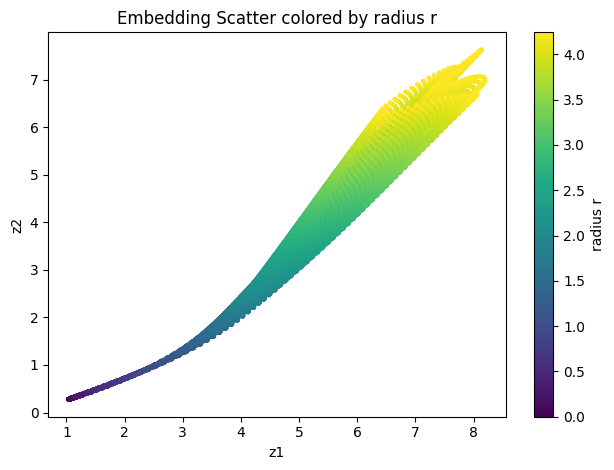

In [23]:
# --------------------
# Plot 1: Embedding scatter (Z[:,0] vs Z[:,1]) colored by radius
# --------------------
plt.figure()
sc = plt.scatter(Z[:, 0], Z[:, 1], s=6, c=radii)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Embedding Scatter colored by radius r")
cb = plt.colorbar(sc)
cb.set_label("radius r")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "embedding_scatter_by_radius.png"), dpi=160)
plt.show()

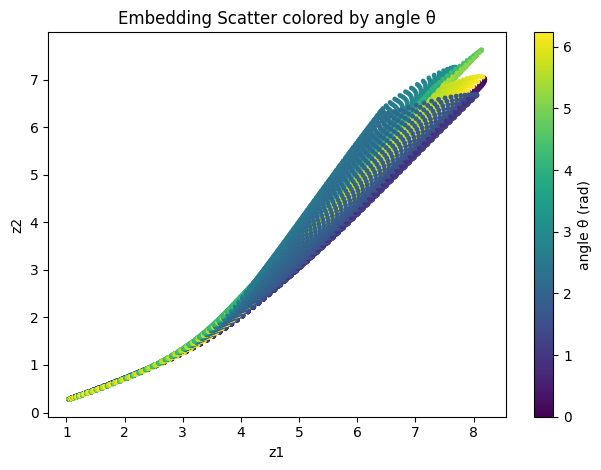

In [24]:
# --------------------
# Plot 2: Embedding scatter colored by angle theta
# --------------------
plt.figure()
sc = plt.scatter(Z[:, 0], Z[:, 1], s=6, c=thetas)
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("Embedding Scatter colored by angle θ")
cb = plt.colorbar(sc)
cb.set_label("angle θ (rad)")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "embedding_scatter_by_theta.png"), dpi=160)
plt.show()

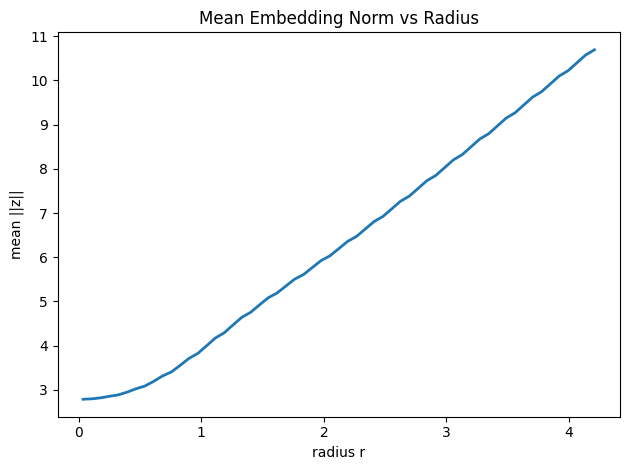

In [25]:
# --------------------
# Plot 3: Mean embedding norm vs radius (angularly averaged)
# --------------------
z_norm = np.linalg.norm(Z, axis=1)
bins = np.linspace(radii.min(), radii.max(), 60)
centers = 0.5 * (bins[:-1] + bins[1:])
mean_norm = []
for lo, hi in zip(bins[:-1], bins[1:]):
    m = (radii >= lo) & (radii < hi)
    if np.any(m):
        mean_norm.append(z_norm[m].mean())
    else:
        mean_norm.append(np.nan)
mean_norm = np.array(mean_norm)

plt.figure()
plt.plot(centers, mean_norm, linewidth=2.0)
plt.xlabel("radius r")
plt.ylabel("mean ||z||")
plt.title("Mean Embedding Norm vs Radius")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "mean_embedding_norm_vs_radius.png"), dpi=160)
plt.show()

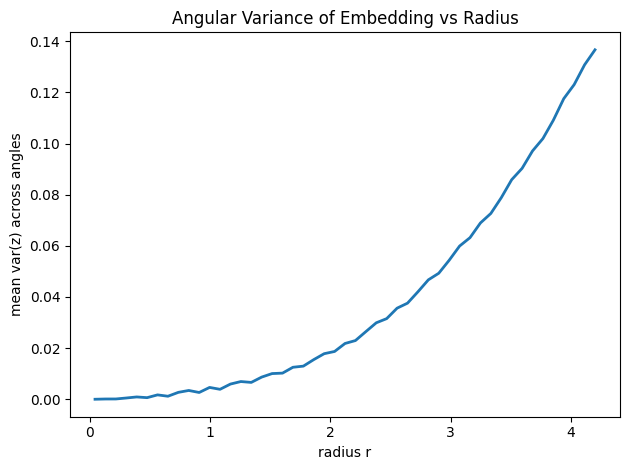

In [26]:
# --------------------
# Plot 4: Angular variance of embedding (average over bins)
# --------------------
bins = np.linspace(radii.min(), radii.max(), 50)
centers = 0.5 * (bins[:-1] + bins[1:])
ang_var = []
for lo, hi in zip(bins[:-1], bins[1:]):
    m = (radii >= lo) & (radii < hi)
    if np.sum(m) > 1:
        var = Z[m].var(axis=0).mean()
        ang_var.append(var)
    else:
        ang_var.append(np.nan)
ang_var = np.array(ang_var)

plt.figure()
plt.plot(centers, ang_var, linewidth=2.0)
plt.xlabel("radius r")
plt.ylabel("mean var(z) across angles")
plt.title("Angular Variance of Embedding vs Radius")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "angular_variance_vs_radius.png"), dpi=160)
plt.show()

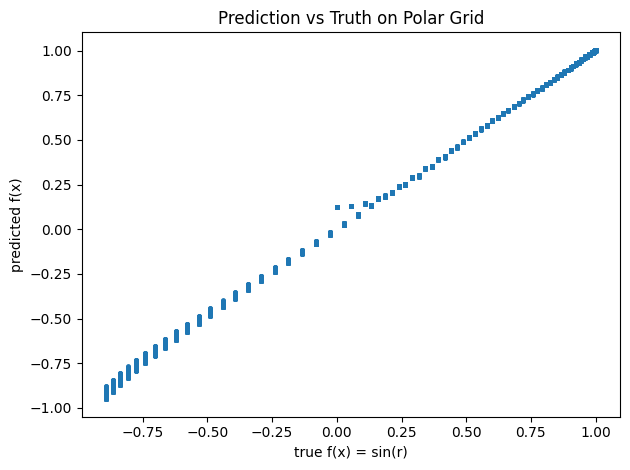

In [27]:
# --------------------
# Plot 5: Predicted f vs True f (scatter)
# --------------------
plt.figure()
plt.scatter(y_true, pred, s=6)
plt.xlabel("true f(x) = sin(r)")
plt.ylabel("predicted f(x)")
plt.title("Prediction vs Truth on Polar Grid")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "pred_vs_true.png"), dpi=160)
plt.show()

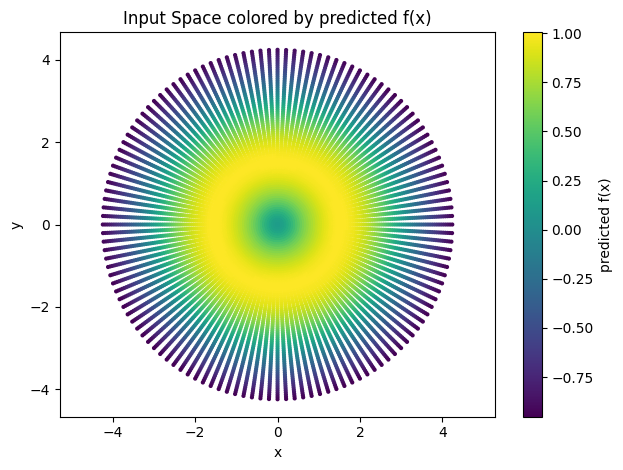

In [28]:
# --------------------
# Plot 6: Input XY colored by prediction
# --------------------
plt.figure()
sc = plt.scatter(XY[:, 0], XY[:, 1], s=4, c=pred)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Input Space colored by predicted f(x)")
cb = plt.colorbar(sc)
cb.set_label("predicted f(x)")
plt.axis("equal")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "xy_colored_by_pred.png"), dpi=160)
plt.show()

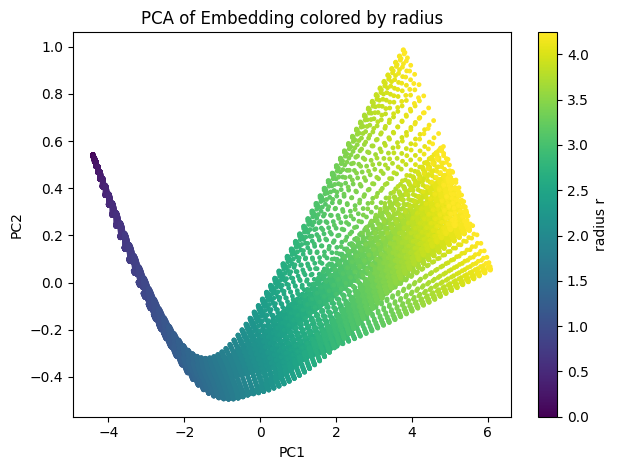

In [29]:
# --------------------
# Plot 7: PCA of embedding (first 2 PCs) colored by radius
# --------------------
Zc = Z - Z.mean(axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(Zc, full_matrices=False)
PC = Zc @ Vt[:2].T  # first 2 principal components

plt.figure()
sc = plt.scatter(PC[:, 0], PC[:, 1], s=6, c=radii)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Embedding colored by radius")
cb = plt.colorbar(sc)
cb.set_label("radius r")
plt.tight_layout()
# plt.savefig(os.path.join(FIGDIR, "pca_embedding_by_radius.png"), dpi=160)
plt.show()

In [30]:
# --------------------
# Numeric summaries
# --------------------
from collections import OrderedDict
summ = OrderedDict()
summ["N"] = int(Z.shape[0])
summ["embed_dim"] = int(Z.shape[1])
summ["mean_z_norm"] = float(np.linalg.norm(Z, axis=1).mean())
summ["std_z_norm"] = float(np.linalg.norm(Z, axis=1).std())
summ["mean_abs_error"] = float(np.mean(np.abs(pred - np.sin(radii))))
summ["rmse"] = float(np.sqrt(np.mean((pred - np.sin(radii))**2)))

for k, v in summ.items():
    print(f"{k}: {v}")

N: 10240
embed_dim: 4
mean_z_norm: 6.326626777648926
std_z_norm: 2.523000955581665
mean_abs_error: 0.009328658692538738
rmse: 0.019928481429815292
